In [1]:
!pip install transformers
!pip install albumentations
!pip install torchmetrics

In [1]:
## STANDARD LIBRARY AND PIPELINE MODULES IMPORT

from  pipeline import segmentation
from pipeline import correct_perspective
from pipeline import text_detection
from pipeline import OCR
from pipeline import classifier

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
%%time
## EVALUATION ON EACH IMAGE
TEST_IMG_DIR = "test_data"
imlis = os.listdir(TEST_IMG_DIR)
imloc = f"{TEST_IMG_DIR}/{imlis[9]}"

image = cv2.cvtColor(cv2.imread(imloc), cv2.COLOR_BGR2RGB)
mask = segmentation.maskPred(image)
# print(mask)
(ocr_io, class_io) =  correct_perspective.correctPerspective(image, mask)
label = classifier.classification(class_io) 

# bounding_boxes = [text_detection.boundingBoxes(ocr_io)]

# print(bounding_boxes)

# fig, ax = plt.subplots(len(bounding_boxes) + 1)

# for idx,bounding_box in enumerate(bounding_boxes):
#     text, crop = OCR.trOCR(ocr_io, bounding_box)

#     print(text)
#     ax[idx].imshow(crop)
# ax[-1].imshow(monitor)

CPU times: user 2.68 s, sys: 24.6 ms, total: 2.71 s
Wall time: 814 ms


In [7]:
print(label)

2


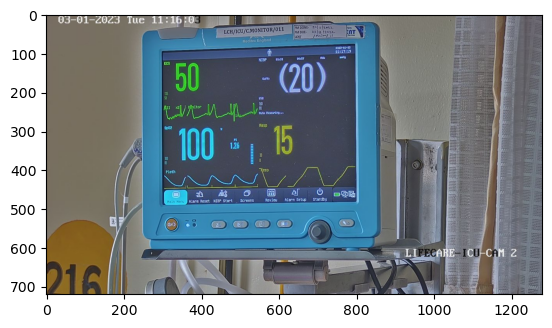

In [9]:
plt.imshow(image)

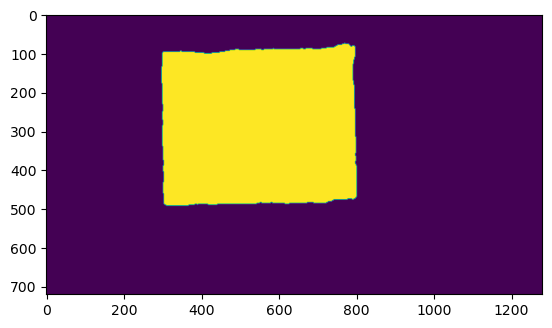

In [10]:
plt.imshow(mask)

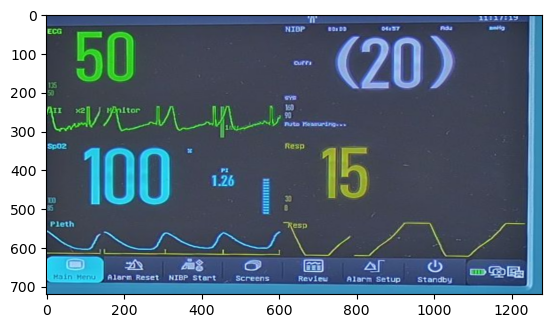

In [11]:
plt.imshow(ocr_io)

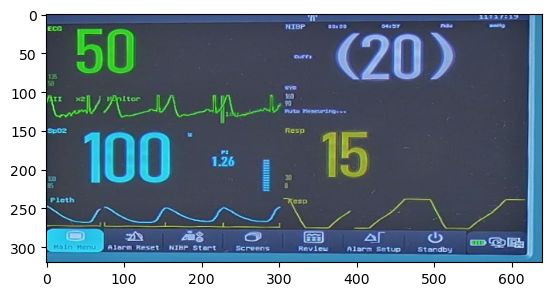

In [12]:
plt.imshow(class_io)